### Battery life model library
Example notebook demonstrating how to use the battery life models in Python.

First examples use the Kokam NMC111|Gr 75Ah battery life model. The battery modeled here is a high-power cell with long cycle life. Because nominal cell resistance is low, the relative change of resistance at end-of-life is quite high compared to other cell designs (~300% increase in cell resistance at 80% capacity if not more). Fade rates can be changed in the code to accomodate other cell models. Documentation is provided in the life model class. See https://ieeexplore.ieee.org/abstract/document/7963578 for the aging test details and results used to parameterize this model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

To run, the life model needs timeseries data: the time in seconds since beginning-of-life of the battery, the state-of-charge of the battery (0 to 1), and the ambient temperature (or battery temperature, if you have a thermal model).


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\pgasper\AppData\Local\anaconda3\envs\blast-lite\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\pgasper\AppData\Local\anaconda3\envs\blast-lite\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\pgasper\AppData\Local\anaconda3\envs\blast-lite\Lib\site-packages\ipykernel\kernelapp

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\pgasper\AppData\Local\anaconda3\envs\blast-lite\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\pgasper\AppData\Local\anaconda3\envs\blast-lite\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\pgasper\AppData\Local\anaconda3\envs\blast-lite\Lib\site-packages\ipykernel\kernelapp

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



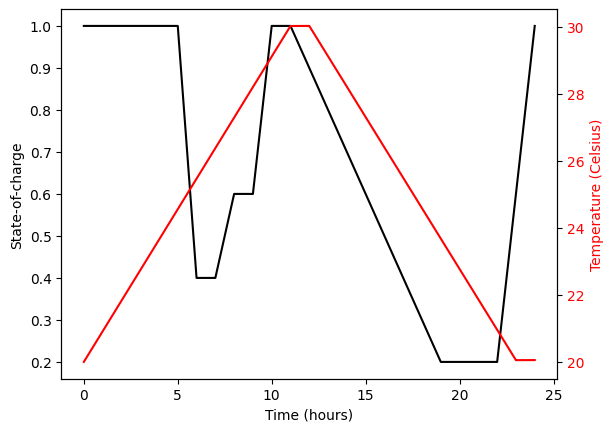

In [2]:
from blast.utils.demo import generate_sample_data

simulation_inputs = generate_sample_data()

fig, ax1 = plt.subplots()
ax1.plot(simulation_inputs['Time_s'][:25] / 3600, simulation_inputs['SOC'][:25], '-k')
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('State-of-charge')

ax2 = ax1.twinx()
ax2.plot(simulation_inputs['Time_s'][:25] / 3600, simulation_inputs['Temperature_C'][:25], '-r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylabel('Temperature (Celsius)', color='r')
plt.show()

Climate or SOC inputs can have any amount of variation: hourly, daily, or seasonal variation.

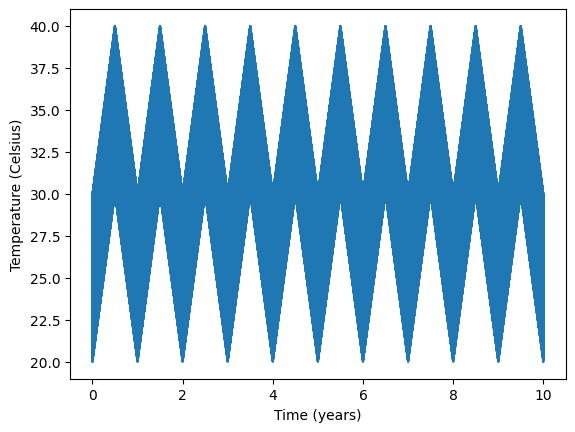

In [3]:
plt.plot(simulation_inputs['Time_s'] / (3600*24*365), simulation_inputs['Temperature_C'])
plt.xlabel('Time (years)')
plt.ylabel('Temperature (Celsius)')
plt.show()

Instantiate the battery model.

In [4]:
from blast.models.nmc111_gr_Kokam75Ah_2017 import Nmc111_Gr_Kokam75Ah_Battery
cell = Nmc111_Gr_Kokam75Ah_Battery()

All battery models have five properties. The first is `cap`, which is the nominal discharge capacity of the cell in Amp hours.

In [5]:
cell.cap

75

The next four track battery lifetime values, and store the history of the battery as lifetime is simulated  at each timestep/iteration:
- `states`: internal states of the battery model
    - Ex., time-dependent capacity loss
- `outputs`: battery properties calculated from states
    - Ex., relative discharge capacity
- `stressors`: values of stressors used by the model
    - Ex., temperature, depth-of-discharge, charge-throughput
    - Note that degradation rates are calculate from stressor timeseries, and then normalized for the timestep; for example, an Arrhenius expression would be evaluated from the temperature timeseries for the entire timestep, and then normalized by taking the time-based average - this gives a different value than if the Arrhenius expression was evaluated on the averager temperature. Other normalizations can include using the minimum or maximum value over the timestep, or using the root-mean-square.
- `rates`: values of degradation rates
    - Ex., time-dependent degradation rate due to temperature and state-of-charge

Battery models may have other properties, such as the open-circuit voltage as a function of state-of-charge, nominal DC resistance values, or first-life/second-life capacity definitions.

This specific battery model is relatively complex, and has many states and outputs that describe the degradation state of the battery. Properties `states`, `outputs`, `stressors`, and `rates` are all stored in dicts:

In [6]:
cell.outputs

{'q': array([1]),
 'q_LLI': array([1]),
 'q_LLI_t': array([1]),
 'q_LLI_EFC': array([1]),
 'q_LAM': array([1.01]),
 'r': array([1]),
 'r_LLI': array([1]),
 'r_LLI_t': array([1]),
 'r_LLI_EFC': array([1]),
 'r_LAM': array([1])}

Output descriptions are in the class definition, replicated here:
- q: relative capacity
- q_LLI: relative lithium inventory
- q_LLI_t: relative lithium inventory, time dependent loss
- q_LLI_EFC: relative lithium inventory, charge-throughput dependent loss
- q_LAM: relative active material, charge-throughput dependent loss
- r: relative resistance
- r_LLI: relative SEI resistance
- r_LLI_t: relative SEI resistance, time dependent growth
- r_LLI_EFC: relative SEI resistance, charge-throughput dependent growth
- r_LAM: relative electrode resistance, q_LAM dependent growth

Accesing one output/state/rate/stressor is simple:

In [7]:
cell.outputs['q']

array([1])

The battery model is run in timesteps relevant to battery degradation: either once a single equivalent full cycle has been completed, or after 1 day. Cycles are detected using the rainflow algorithm, which finds turning points in the SOC profile that are then processed to determine useful simulation timesteps from the SOC profile. This is all done by the `simulate_battery_life` function. The input timeseries vectors needs to be given as a dictionary.

Each battery model tracks the history of it's inputs (`stressors`), calculated degradation rates (`rates`), internal states (`states`), and outputs (`outputs`) each time `update_battery_state` is called. Debugging models is easier because the values of all inputs, internal calculations, and outputs are tracked.

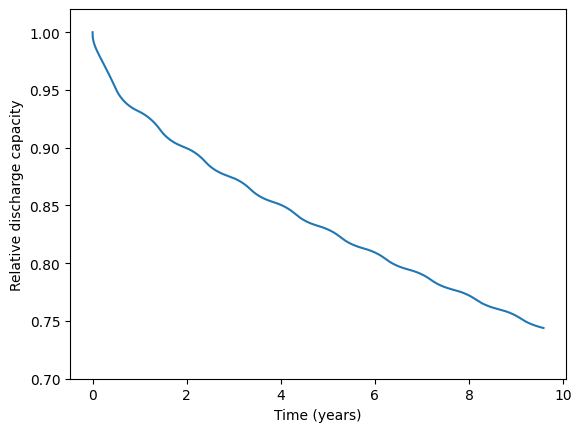

In [8]:
cell.simulate_battery_life(simulation_inputs)

plt.plot(cell.stressors['t_days']/365, cell.outputs['q'])
plt.xlabel('Time (years)')
plt.ylabel('Relative discharge capacity')
plt.ylim((0.7, 1.02))
plt.show()

The cell resistance and capacity trajectories are wiggily because the temperature of the battery is varying throughout each year, varying the degradation rate. Dispatch is the same each day, so that is constant.

The model keeps track of how much charge-throughput has occured throughout life, as well, based on the input state-of-charge timeseries. Conversion from charge-throughput, in Amp-hours, to changes of cell state-of-charge, which is dependent on battery performance (health, temperature and SOC dependent resistances), is assumed to happen externally to the model. This simple simulation is essentially assuming that the current magnitude is continuously being adjusted based on the the state-of-health of the battery.

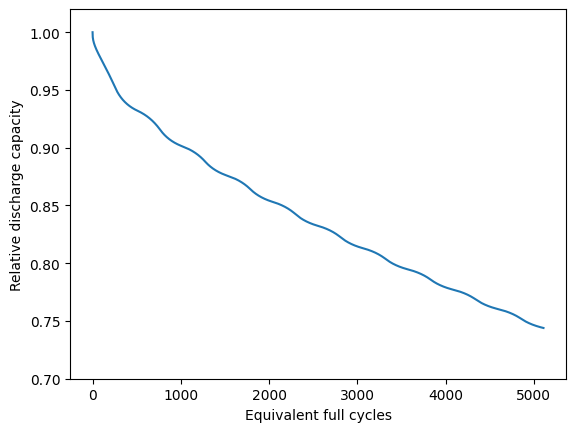

In [9]:
plt.plot(cell.stressors['efc'], cell.outputs['q'])
plt.xlabel('Equivalent full cycles')
plt.ylabel('Relative discharge capacity')
plt.ylim((0.7, 1.02))
plt.show()

This dispatch has a little more than 1 EFC per day.

We can plot the separate contributions to capacity or resistance fade, as well.

(0.7, 1.02)

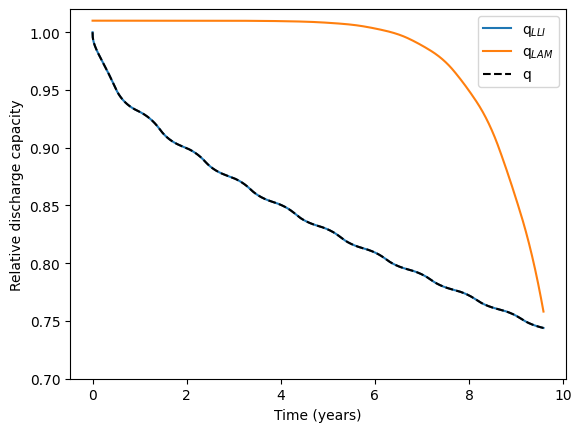

In [10]:
plt.plot(cell.stressors['t_days']/365, cell.outputs['q_LLI'])
plt.plot(cell.stressors['t_days']/365, cell.outputs['q_LAM'])
plt.plot(cell.stressors['t_days']/365, cell.outputs['q'], '--k')
plt.xlabel('Time (years)')
plt.ylabel('Relative discharge capacity')
plt.legend([r'q$_{LLI}$', r'q$_{LAM}$', 'q'])
plt.ylim((0.7, 1.02))

From the result, the cell will experience sudden failure very shortly; considering this is near 70% remaining capacity, this is physically reasonable.

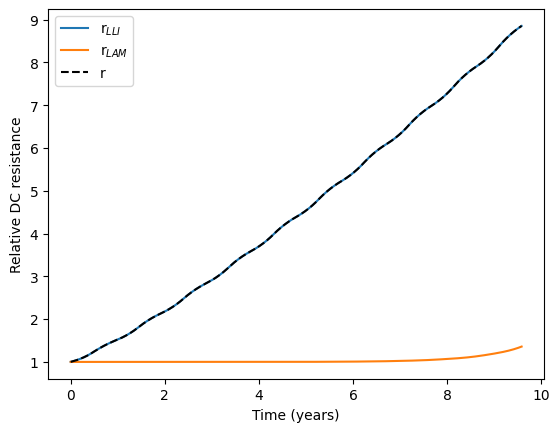

In [11]:
plt.plot(cell.stressors['t_days']/365, cell.outputs['r_LLI'])
plt.plot(cell.stressors['t_days']/365, cell.outputs['r_LAM'])
plt.plot(cell.stressors['t_days']/365, cell.outputs['r'], '--k')
plt.xlabel('Time (years)')
plt.ylabel('Relative DC resistance')
plt.legend([r'r$_{LLI}$', r'r$_{LAM}$', 'r'])
plt.show()

Repeat with other battery life models.

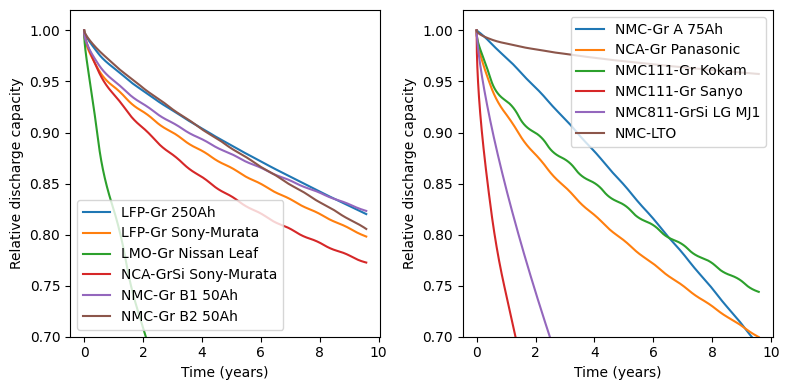

In [30]:
from blast import models
import importlib

def simulate_all_models(*args, **kwargs):
    battery_models = models.available_models()
    cells = []
    for model in battery_models:
        This_Battery_Model = getattr(importlib.import_module("blast.models"), model)
        cell = This_Battery_Model()
        cell.simulate_battery_life(*args, **kwargs)
        cells.append(cell)
    
    return cells

cells = simulate_all_models(simulation_inputs)

fig, ax = plt.subplots(1, 2, figsize=(8,4))
for i, cell in enumerate(cells):
    if i < 6:
        ax[0].plot(cell.stressors['t_days']/365, cell.outputs['q'], label=cell._label)
    else:
        ax[1].plot(cell.stressors['t_days']/365, cell.outputs['q'], label=cell._label)

for axis in ax:
    axis.set_xlabel('Time (years)')
    axis.set_ylabel('Relative discharge capacity')
    axis.set_ylim((0.7, 1.02))
    axis.legend()
plt.tight_layout()